Execute the selected model on the provided video.

The model processes 5 seconds of video (50 frames) at a time in a sliding window fashion. Then, the predictions are stored in a sequence of bar plots that can be used to render the predictions video.

In [1]:
VIDEO_PATH = 'videos/Will_Smith.avi'
MODEL_PATH = 'models/best_model.h5'
SLIDING_STEP = 51 # number of frames to slide the window forward in the sliding window for prediction

# Imports

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
!export TF_FORCE_GPU_ALLOW_GROWTH=True
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2022-07-31 13:46:14.077118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:46:14.078174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:46:14.080030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:46:14.085651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:46:14.086863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

# Load video

In [4]:
FPS = 10
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3
INPUT_FRAMES = 50 + 1  # number of frames that the model receives

In [5]:
def load_video(video_path=VIDEO_PATH):
    cap = cv2.VideoCapture(video_path)

    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    original_fps = int(cap.get(cv2.CAP_PROP_FPS))

    if n_frames / original_fps < 5:
        print(f'[!] Video should be at least 5 seconds long')

    n_frames_to_keep = int(FPS/original_fps * n_frames  + 1)  # +1 is needed for frame_diff

    # Select frames equally spaced
    frames_idx = set(np.round(np.linspace(0, n_frames - 1, n_frames_to_keep)).astype(int))

    frames = []
    index = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if index in frames_idx:
            frame = cv2.resize(frame, (VIDEO_WIDTH, VIDEO_HEIGHT)).astype(np.float32)
            frames.append(frame)
        index += 1
    cap.release()

    return np.array([frames[i:i+INPUT_FRAMES] for i in range(0, len(frames) - INPUT_FRAMES + 1, SLIDING_STEP)])

In [6]:
raw_video = load_video()
skeletons_video = load_video(VIDEO_PATH[:-len('.avi')] + '_skeletons.avi' )

In [7]:
raw_video.shape, skeletons_video.shape

((16, 51, 100, 100, 3), (16, 51, 100, 100, 3))

# Load trained model

In [8]:
model = tf.keras.models.load_model('models/best_model.h5')

2022-07-31 13:46:17.788982: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-31 13:46:18.124398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:46:18.125627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:46:18.127466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Prediction

In [9]:
predictions = model.predict([raw_video, skeletons_video])

2022-07-31 13:46:22.151732: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2022-07-31 13:46:25.225793: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


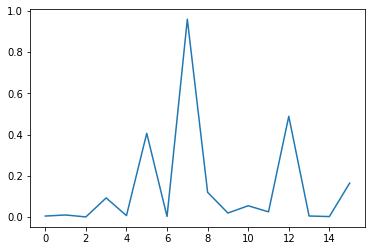

In [10]:
plt.plot(predictions)

# Animation

Output example of first prediction:


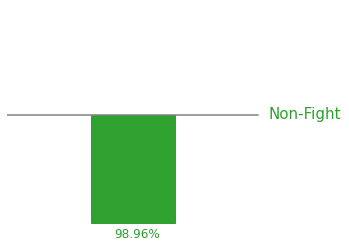

In [11]:
for idx, prediction in enumerate(predictions):
    pred = 2 * (prediction - 0.5)

    if pred == 0:
        color = 'grey'
        text = 'Neutral'
    elif pred > 0:
        color = 'tab:red'
        text = 'Fight'
    else:
        color = 'tab:green'
        text = 'Non-Fight'
    
    plt.bar([0.3], pred, width=0.2, color=color, alpha=abs(pred[0]), edgecolor=color)
    sign = .7 if pred > 0 else -1.3
    plt.text(0.255, pred[0] + sign*.1, f'{abs(pred[0]):.2%}', color=color, fontdict={'fontsize': 12})
    plt.plot([.0,.6], [0,0], color='grey')

    plt.text(.665 if pred > 0 else .625, -0.03, f'{text}', color=color, fontdict={'fontsize': 15})
    
    plt.ylim(-1, 1)
    plt.xlim(0, .8)
    plt.axis('off')
    plt.savefig(f'predictions/{VIDEO_PATH}-{idx}.png')
    if idx == 0:
        print('Output example of first prediction:')
        plt.show()
    plt.close()